In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import datetime
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
from scipy import signal
from scipy import stats
from tqdm import tqdm
from shapely.wkt import loads
from shapely.geometry import Point
from statsmodels.tsa.stattools import acf, pacf

In [2]:
stations_debit = pd.read_csv("../Data/Base/Stations_Debit.csv")
stations_meteo = pd.read_csv("../Data/Base/Stations_Meteo.csv")
mesures = pd.read_csv("../Data/Base_journalier/Mesures_Train_X.csv")
mesures["Date"] = pd.to_datetime(mesures["Date"], format = "%Y/%m/%d %H:%M:%S")

## Explorations

In [3]:
n_cours_eau = 3
cours_eau = list(np.unique(stations_debit["Cours eau"]))
cours_eau_cmap = cm.get_cmap(ListedColormap(["red", "green", "blue"]))
cours_eau_couleur = pd.DataFrame({"Cours eau": cours_eau, "Index": range(n_cours_eau), "Couleur": ["red", "green", "blue"]})
cours_eau_couleur

,Cours eau,Index,Couleur
0,Garonne,0,red
1,Loire,1,green
2,Seine,2,blue


In [4]:
stations_debit.loc[:,"geometry"] = stations_debit['geometry'].apply(loads)
stations_debit = stations_debit.replace(to_replace=cours_eau, value=range(len(cours_eau)))
stations_debit = gpd.GeoDataFrame(stations_debit,
                                   geometry = "geometry")
liste_stations = list(stations_debit["Code station"])
stations_debit

,Code station,Libelle station,Regime influencé,Altitude du zéro de l'échelle,geometry,Ordre,Cours eau
0,O0200020,La Garonne [partielle] à Saint-Gaudens [Valent...,pas ou faiblement,357.00,POINT (0.70680 43.09775),0,0
1,O2620010,La Garonne à Verdun-sur-Garonne,pas ou faiblement,90.00,POINT (1.24218 43.85463),1,0
2,O6140010,La Garonne à Lamagistère,pas ou faiblement,46.00,POINT (0.83130 44.12107),2,0
3,O9000010,La Garonne à Tonneins,pas ou faiblement,0.00,POINT (0.22215 44.41193),3,0
4,K0030020,La Loire à Issarlès [Pont de La Borie],fortement,881.34,POINT (4.04849 44.81973),0,1
5,K0100020,La Loire à Goudet,fortement,0.00,POINT (3.92189 44.88905),1,1
6,K0260020,La Loire à Chadrac [Pont du Monteil à Chadrac],fortement en étiage,589.50,POINT (3.90369 45.06796),2,1
7,K0550010,La Loire à Bas-en-Basset,fortement,442.00,POINT (4.11799 45.29523),3,1
8,K0690010,La Loire à Montrond-les-Bains,fortement,339.11,POINT (4.22536 45.64333),4,1
9,K0910050,La Loire à Villerest [Pont de Villerest],fortement,267.51,POINT (4.04622 45.99586),5,1


<AxesSubplot:>

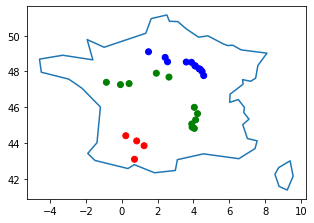

In [5]:
# On a 26 stations
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
france = world[world['name'] == "France"].geometry.explode().values[[1, 2]].unary_union()
base = gpd.GeoSeries(france).boundary.plot(figsize = (5, 5))
stations_debit.plot(ax = base, color = cours_eau_cmap(stations_debit["Cours eau"]))

In [6]:
mesures_2010 = mesures[mesures["Date"].apply(lambda x: x.year) == 2010]
mesures_2010

,Date,O0200020,O2620010,O6140010,O9000010,K0030020,K0100020,K0260020,K0550010,K0690010,...,Temperature_07747,Humidite_07747,Precipitations_07747,Pression_07761,Vent_Nord_07761,Vent_Est_07761,Vitesse_vent_07761,Temperature_07761,Humidite_07761,Precipitations_07761
0,2010-01-01,42.375000,128.000000,350.500000,490.583333,0.535000,3.119167,11.005000,24.850000,8.470833,...,10.838889,54.916667,0.027778,99468.888889,-3.102706,-10.306272,11.608333,12.455556,78.805556,0.527778
1,2010-01-02,38.458333,106.175000,447.666667,666.333333,0.467500,2.952500,10.812500,29.208333,8.045000,...,5.402778,62.138889,0.000000,100958.611111,0.599922,-5.787958,6.166667,11.091667,57.361111,0.005556
2,2010-01-03,35.891667,104.941667,385.000000,690.333333,0.423333,2.385833,8.619167,21.000000,7.295833,...,4.850000,66.916667,0.000000,101789.722222,0.935041,1.516902,3.294444,6.633333,63.944444,0.000000
3,2010-01-04,34.041667,92.708333,343.333333,607.833333,0.424167,2.447500,8.489167,21.616667,42.940000,...,5.375000,83.027778,0.022222,101092.500000,1.822732,1.671234,2.491667,8.925000,85.000000,0.066667
4,2010-01-05,37.175000,109.258333,357.083333,616.666667,0.421667,2.426667,8.027500,23.250000,56.650000,...,6.783333,87.361111,0.333333,99866.666667,1.063713,1.520201,2.219444,10.800000,93.111111,1.127778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,2010-12-27,30.816667,82.683333,375.750000,700.250000,1.991667,20.208333,31.441667,85.416667,122.833333,...,2.394444,50.305556,0.000000,101709.166667,-0.241423,1.157019,2.991667,7.583333,77.361111,0.000000
361,2010-12-28,33.733333,97.733333,365.166667,718.000000,1.932500,15.383333,29.150000,81.716667,118.583333,...,4.677778,82.138889,0.000000,102081.111111,1.210243,1.304838,2.105556,7.447222,83.305556,0.000000
362,2010-12-29,31.500000,95.241667,339.833333,654.666667,1.808333,12.508333,28.225000,78.550000,116.000000,...,6.775000,90.138889,0.000000,102073.333333,1.117049,1.369730,2.027778,9.763889,85.555556,0.000000
363,2010-12-30,31.550000,82.100000,314.583333,544.250000,1.735000,11.791667,27.158333,73.950000,116.500000,...,9.125000,91.500000,0.000000,101951.388889,0.561546,1.062101,2.072222,10.480556,85.694444,0.000000


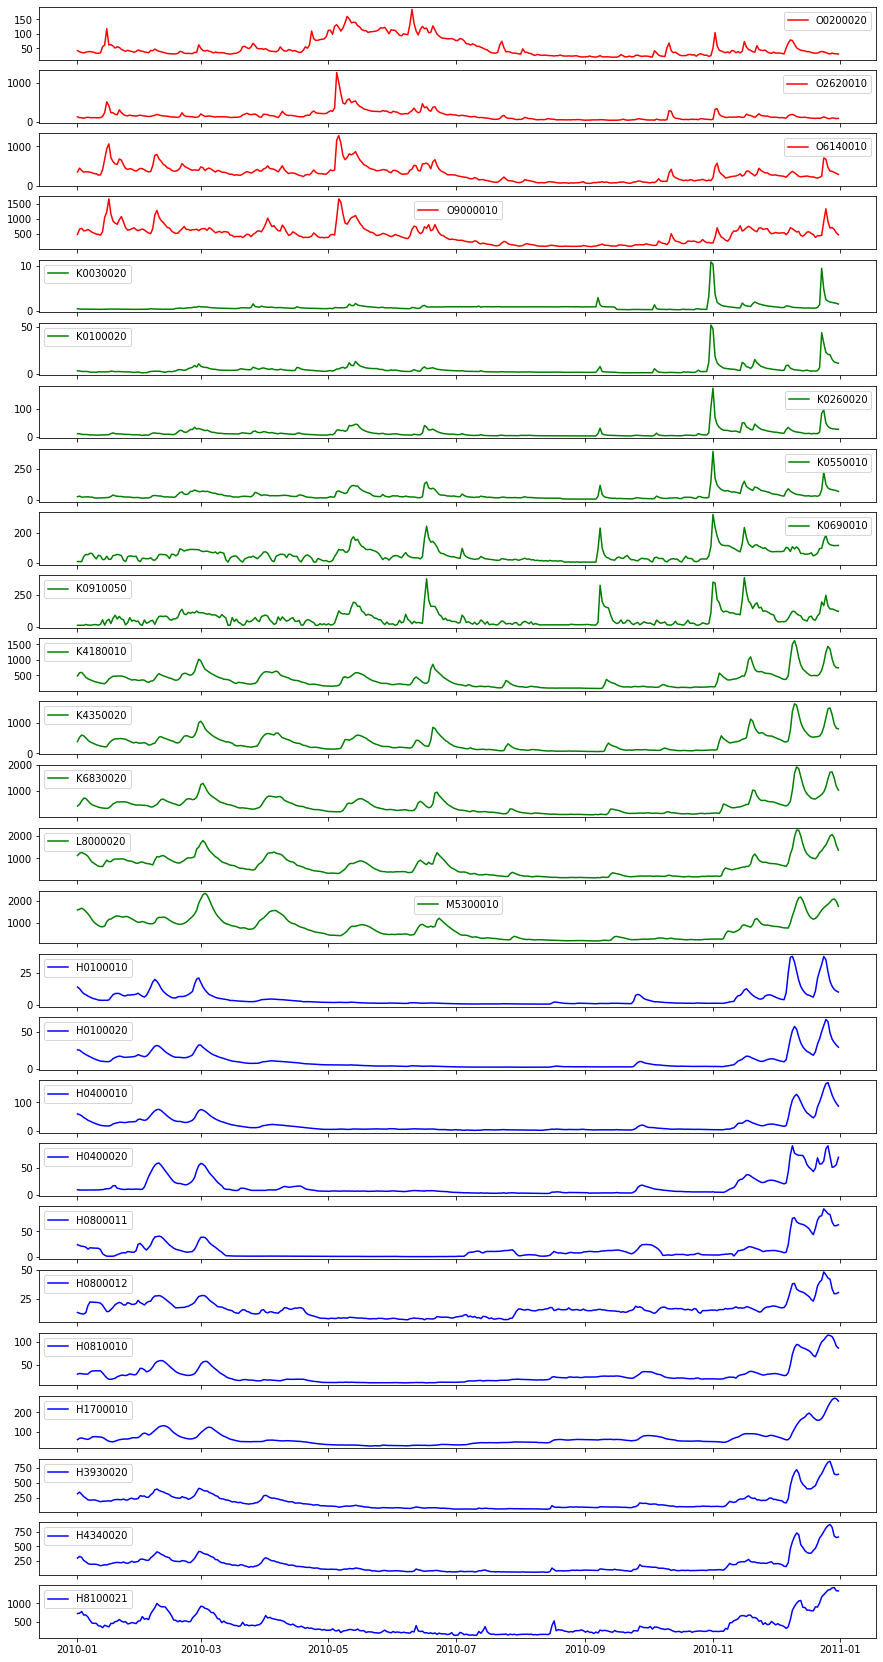

In [7]:
n_stations = stations_debit.shape[0]
fig, axs = plt.subplots(n_stations, 1, figsize = (15,30), sharex=True)
for i in range(n_stations):
    code = stations_debit.iloc[i]["Code station"]
    axs[i].plot(mesures_2010["Date"], mesures_2010[code], label = code, 
                color = cours_eau_cmap(stations_debit.iloc[i]["Cours eau"]))
    axs[i].legend()

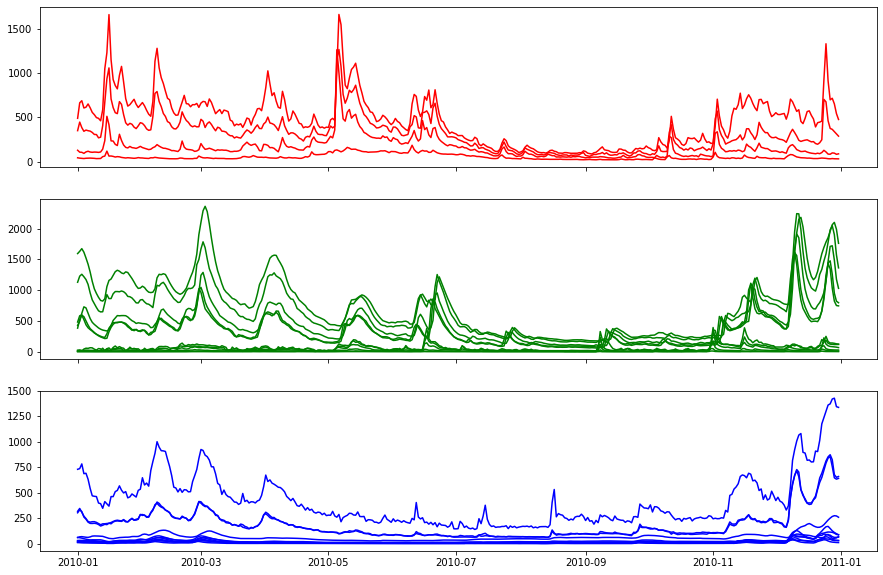

In [8]:
fig, axs = plt.subplots(n_cours_eau, 1, figsize = (15,10), sharex=True)
for i in range(n_cours_eau):
    stations = list(stations_debit[stations_debit["Cours eau"] == i]["Code station"])
    for code in stations:
        axs[i].plot(mesures_2010["Date"], mesures_2010[code],
                   color = cours_eau_cmap(i))

On regarde les distributions en fonction des fleuves.

In [10]:
# Pour chaque station, on regarde les quantiles, la moyenne, la variance, et on regarde les distrib
n_stations = stations_debit.shape[0]

stations_debit["Moyenne"] = [mesures[code].mean() for code in stations_debit["Code station"]]
stations_debit["Variance"] = [mesures[code].var() for code in stations_debit["Code station"]]
stations_debit["q025"] = [mesures[code].quantile(q = 0.25) for code in stations_debit["Code station"]]
stations_debit["q05"] = [mesures[code].quantile(q = 0.5) for code in stations_debit["Code station"]]
stations_debit["q075"] = [mesures[code].quantile(q = 0.75) for code in stations_debit["Code station"]]

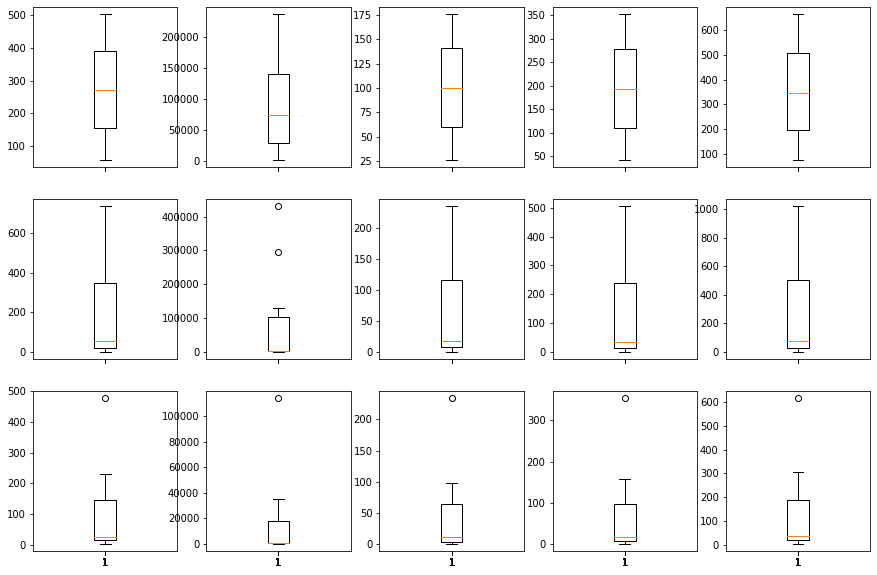

In [11]:
fig, axs = plt.subplots(n_cours_eau, 5, figsize = (15,10), sharex=True)
for i in range(n_cours_eau):
    axs[i, 0].boxplot(stations_debit[stations_debit["Cours eau"] == i]["Moyenne"])
    axs[i, 1].boxplot(stations_debit[stations_debit["Cours eau"] == i]["Variance"])
    axs[i, 2].boxplot(stations_debit[stations_debit["Cours eau"] == i]["q025"])
    axs[i, 3].boxplot(stations_debit[stations_debit["Cours eau"] == i]["q05"])
    axs[i, 4].boxplot(stations_debit[stations_debit["Cours eau"] == i]["q075"])

On regarde si la moyenne et la variance bougent significativement en fonction des mois.

In [12]:
for current_month in range(1,13):
    mesures_month = mesures[mesures["Date"].apply(lambda x: x.month) == current_month]
    stations_debit["Moyenne_" + str(current_month)] = [mesures_month[code].mean() for code in stations_debit["Code station"]]
    stations_debit["Variance_" + str(current_month)] = [mesures_month[code].var() for code in stations_debit["Code station"]]

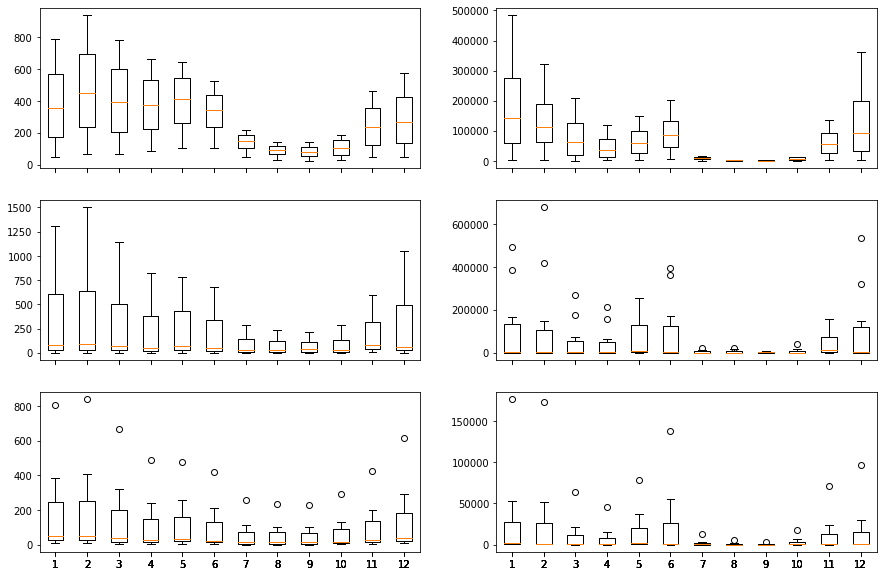

In [13]:
fig, axs = plt.subplots(n_cours_eau, 2, figsize = (15,10), sharex=True)
for i in range(n_cours_eau):
    data = []
    for current_month in range(1,13):
        data.append(list(stations_debit[stations_debit["Cours eau"] == i]["Moyenne_" + str(current_month)]))
    axs[i,0].boxplot(data)
    data = []
    for current_month in range(1,13):
        data.append(list(stations_debit[stations_debit["Cours eau"] == i]["Variance_" + str(current_month)]))
    axs[i,1].boxplot(data)

Autocorrélations

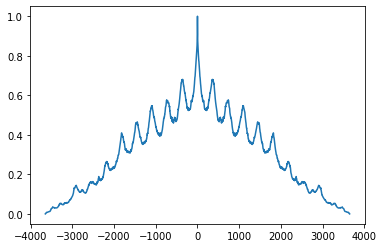

In [14]:
station = stations_debit["Code station"][0]
corr= signal.correlate(mesures[station], mesures[station], mode = "full")
corr /= np.max(corr)

origine = len(mesures)-1
plt.plot([i-origine for i in range(len(mesures)*2-1)], corr)
# On voit déjà qu'il faut prendre en compte la saisonnalité

### Desaisonnalisation Méthode 1
On essaie un truc à la zob, fait la moyenne pour chaque date/heure, et on enlève.

In [15]:
saisonnalite = pd.DataFrame({"Mois": range(1,13)})
saisonnalite = saisonnalite.merge(pd.DataFrame({"Jour": range(1,32)}), how = "cross")
saisonnalite 

,Mois,Jour
0,1,1
1,1,2
2,1,3
3,1,4
4,1,5
...,...,...
367,12,27
368,12,28
369,12,29
370,12,30


In [16]:
mesures_stations = mesures[["Date"] + list(stations_debit["Code station"])]
compo_stations = []
for curr_mois in tqdm(range(1,13)):
    mesures_mois = mesures_stations[mesures_stations["Date"].apply(lambda x: x.month == curr_mois)]
    for curr_jour in range(1,32):
        mesures_jour = mesures_mois[mesures_mois["Date"].apply(lambda x: x.day == curr_jour)]
        if len(mesures_jour)>0:
            compo = list(mesures_jour[list(stations_debit["Code station"])].mean())
            compo_stations.append(compo)
        else:
            compo = [np.nan for i in range(n_stations)]
            compo_stations.append(compo)


100%|██████████| 12/12 [00:00<00:00, 14.61it/s]


In [17]:
saisonnalite[list(stations_debit["Code station"])] = compo_stations
saisonnalite

,Mois,Jour,O0200020,O2620010,O6140010,O9000010,K0030020,K0100020,K0260020,K0550010,...,H0100020,H0400010,H0400020,H0800011,H0800012,H0810010,H1700010,H3930020,H4340020,H8100021
0,1,1,37.950000,123.185000,302.741667,472.675000,0.848833,4.207667,13.633750,39.354750,...,21.452083,53.043167,33.789250,32.196417,21.699750,48.715000,114.886667,339.469167,357.203333,776.916667
1,1,2,37.522500,122.715833,319.358333,491.191667,0.836750,4.148167,13.329250,38.575250,...,22.185083,53.854583,35.473667,34.398083,22.550750,50.154167,115.040833,342.889167,368.079167,798.808333
2,1,3,44.159167,144.920833,340.150000,527.850000,0.808083,3.873000,12.917833,38.042083,...,22.100917,53.924167,36.327583,35.436167,22.836500,52.350000,115.035833,344.790833,367.588333,799.275000
3,1,4,43.659167,150.665000,380.025000,618.525000,0.855750,4.282417,13.934000,40.526667,...,23.197250,55.612500,36.452917,37.306583,23.958000,54.192500,115.811667,344.009167,369.975000,806.416667
4,1,5,44.005000,162.085000,417.383333,687.041667,0.810167,3.937167,13.658667,40.865000,...,24.994667,58.562500,34.471500,37.281250,23.837000,56.059167,117.492500,356.188333,374.683333,801.300000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
367,12,27,41.748333,129.311667,340.000833,523.208333,1.101583,6.308250,16.773333,45.530000,...,23.975167,62.127750,36.250167,35.949500,24.284833,55.001667,121.065833,374.721667,398.434167,818.925000
368,12,28,46.502500,160.229167,359.689167,540.916667,1.084917,5.784917,16.091250,45.090583,...,23.339250,60.730667,34.232250,35.346167,23.504917,55.775833,125.255000,365.837500,394.405000,833.408333
369,12,29,43.631667,154.577500,391.383333,600.608333,1.025333,5.162083,15.465083,43.668333,...,22.556917,58.459083,34.191500,33.288000,22.714833,56.070833,128.299167,364.013333,385.037500,831.633333
370,12,30,41.283333,140.202500,338.791667,536.208333,0.990250,4.846917,14.332500,40.765000,...,21.902250,57.045833,34.536667,33.906917,22.832750,54.170000,129.305000,368.360833,390.310833,836.533333


In [18]:
mesures_debit_desaison = mesures[["Date"]].copy()
for code in tqdm(stations_debit["Code station"]):
    mesures_station = mesures[["Date", code]].copy()
    mesures_station["Mois"] = mesures_station["Date"].apply(lambda x: x.month)
    mesures_station["Jour"] = mesures_station["Date"].apply(lambda x: x.day)
    mesures_station = mesures_station.merge(saisonnalite[["Mois", "Jour", code]], how = "left", suffixes=(None, "_saison"),
                                            on = ["Mois", "Jour"])
    mesures_debit_desaison[code] = mesures_station[code] - mesures_station[code+"_saison"]

100%|██████████| 26/26 [00:00<00:00, 30.51it/s]


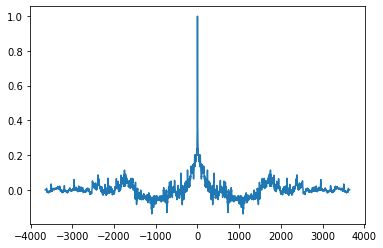

In [21]:
station = stations_debit["Code station"][1]
corr= signal.correlate(mesures_debit_desaison[station], mesures_debit_desaison[station], mode = "full")
corr /= np.max(corr)

origine = len(mesures_debit_desaison)-1
plt.plot([i-origine for i in range(len(mesures_debit_desaison)*2-1)], corr)

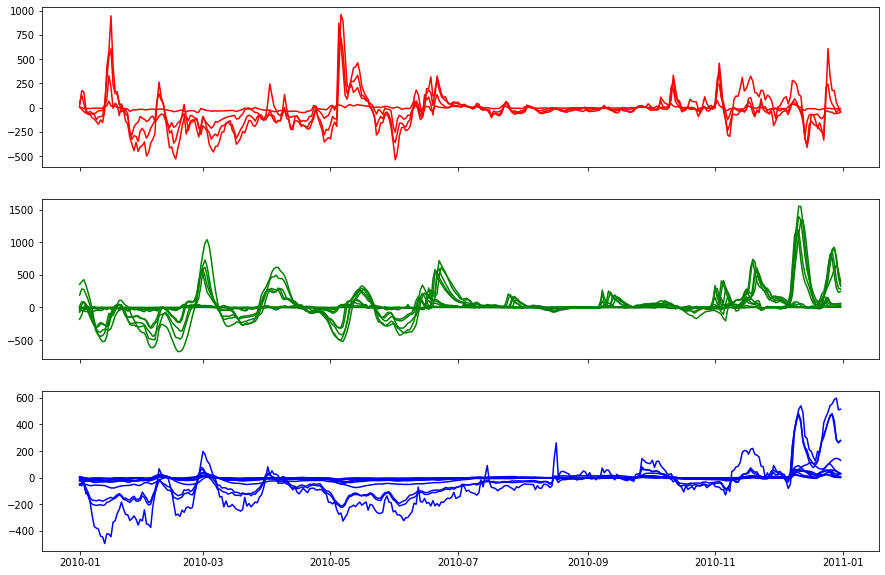

In [22]:
fig, axs = plt.subplots(n_cours_eau, 1, figsize = (15,10), sharex=True)
for i in range(n_cours_eau):
    stations = list(stations_debit[stations_debit["Cours eau"] == i]["Code station"])
    for code in stations:
        axs[i].plot(mesures_2010["Date"], mesures_debit_desaison[mesures_debit_desaison["Date"].apply(lambda x: x.year == 2010)][code],
                   color = cours_eau_cmap(i))

C'est quand même mieux

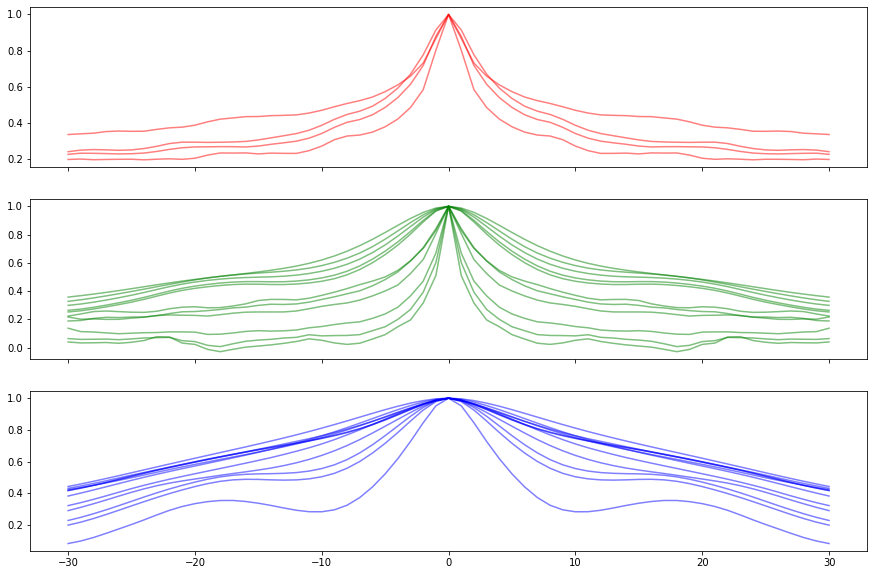

In [25]:
fig, axs = plt.subplots(n_cours_eau, 1, figsize = (15,10), sharex=True)
origine = len(mesures_debit_desaison)-1
max_lag = 30 # 1 mois
for i in range(n_cours_eau):
    stations = list(stations_debit[stations_debit["Cours eau"] == i]["Code station"])
    for code in stations:
        corr= signal.correlate(mesures_debit_desaison[code], mesures_debit_desaison[code], mode = "full")
        corr /= np.max(corr)
        axs[i].plot([i-max_lag for i in range(max_lag*2+1)], corr[(origine-max_lag):(origine+max_lag+1)],
                   color = cours_eau_cmap(i),
                   alpha = 0.5)

On regarde la PACF

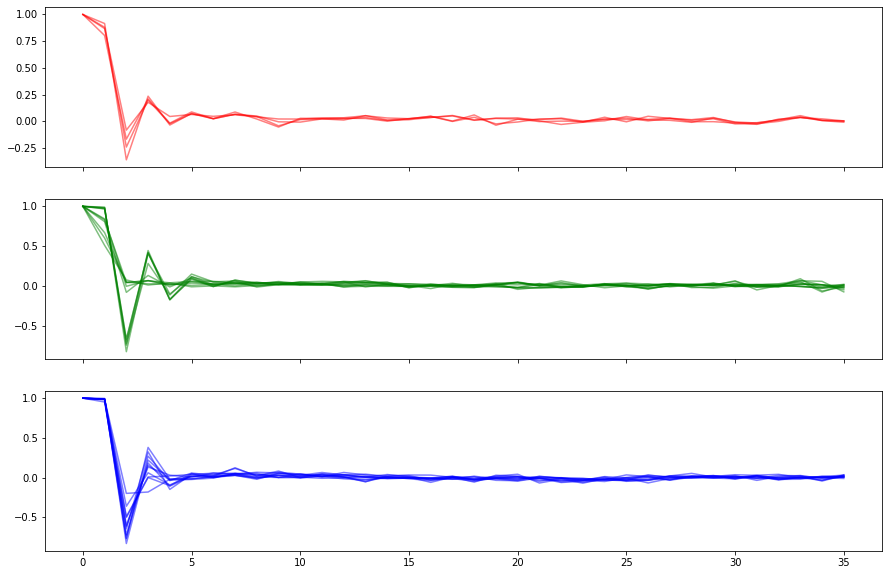

In [26]:
fig, axs = plt.subplots(n_cours_eau, 1, figsize = (15,10), sharex=True)
origine = len(mesures_debit_desaison)-1
max_lag = 30 # 1 mois
for i in range(n_cours_eau):
    stations = list(stations_debit[stations_debit["Cours eau"] == i]["Code station"])
    for code in stations:
        corr= pacf(mesures_debit_desaison[code], method = "ols-adjusted")
        axs[i].plot(corr,
                   color = cours_eau_cmap(i),
                   alpha = 0.5)

Correlation croisées

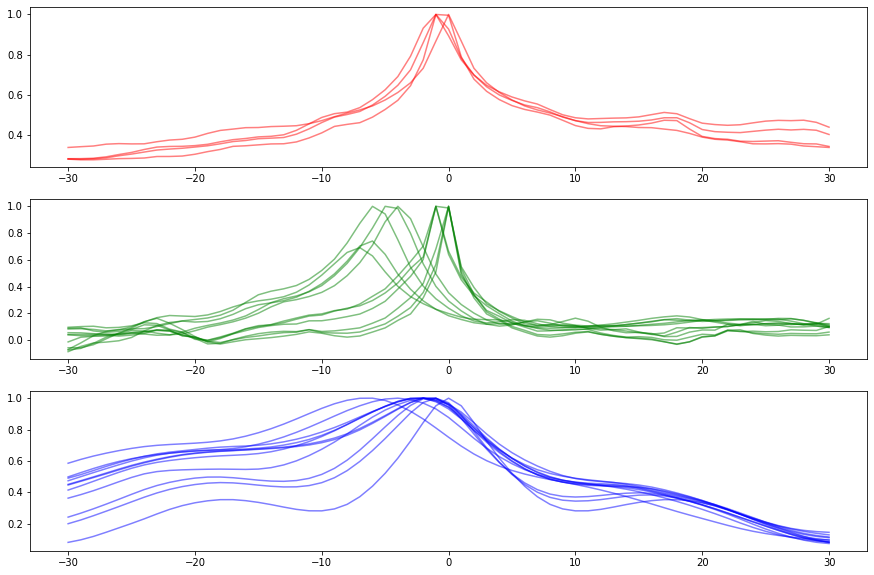

In [27]:
fig, axs = plt.subplots(n_cours_eau, 1, figsize = (15,10))
origine = len(mesures_debit_desaison)-1
max_lag = 30 # 1 mois

for i in range(n_cours_eau):
    station_amont = stations_debit[(stations_debit["Cours eau"] == i) & (stations_debit["Ordre"] == 0)]["Code station"].values[0]
    stations = list(stations_debit[stations_debit["Cours eau"] == i]["Code station"])
    for code in stations:
        corr= signal.correlate(mesures_debit_desaison[station_amont], mesures_debit_desaison[code], mode = "full")
        corr /= np.max(corr)
        axs[i].plot([i-max_lag for i in range(max_lag*2+1)], corr[(origine-max_lag):(origine+max_lag+1)],
                   color = cours_eau_cmap(i),
                   alpha = 0.5)

In [46]:
mesures_meteo = pd.DataFrame()
types_meteo = ["Pression", "Vent_Nord", "Vent_Est", "Vitesse_vent", "Temperature", "Humidite", "Precipitations"]
liste_stations_meteo = list(stations_meteo["ID"].apply(lambda x: str(x).rjust(5, "0")))
for code in liste_stations_meteo:
    mesures_station = mesures[[tpe + "_" + code for tpe in types_meteo]]
    mesures_meteo = pd.concat([mesures_meteo, mesures_station], axis = 1)
mesures_debit_desaison = pd.concat([mesures_debit_desaison, mesures_meteo], axis = 1)
mesures_debit_desaison

,Date,O0200020,O2620010,O6140010,O9000010,K0030020,K0100020,K0260020,K0550010,K0690010,...,Temperature_07747,Humidite_07747,Precipitations_07747,Pression_07761,Vent_Nord_07761,Vent_Est_07761,Vitesse_vent_07761,Temperature_07761,Humidite_07761,Precipitations_07761
0,2010-01-01,4.425000,4.815000,47.758333,17.908333,-0.313833,-1.088500,-2.628750,-14.504750,-35.386083,...,10.838889,54.916667,0.027778,99468.888889,-3.102706,-10.306272,11.608333,12.455556,78.805556,0.527778
1,2010-01-02,0.935833,-16.540833,128.308333,175.141667,-0.369250,-1.195667,-2.516750,-9.366917,-42.757833,...,5.402778,62.138889,0.000000,100958.611111,0.599922,-5.787958,6.166667,11.091667,57.361111,0.005556
2,2010-01-03,-8.267500,-39.979167,44.850000,162.483333,-0.384750,-1.487167,-4.298667,-17.042083,-47.311167,...,4.850000,66.916667,0.000000,101789.722222,0.935041,1.516902,3.294444,6.633333,63.944444,0.000000
3,2010-01-04,-9.617500,-57.956667,-36.691667,-10.691667,-0.431583,-1.834917,-5.444833,-18.910000,-20.167667,...,5.375000,83.027778,0.022222,101092.500000,1.822732,1.671234,2.491667,8.925000,85.000000,0.066667
4,2010-01-05,-6.830000,-52.826667,-60.300000,-70.375000,-0.388500,-1.510500,-5.631167,-17.615000,-8.812500,...,6.783333,87.361111,0.333333,99866.666667,1.063713,1.520201,2.219444,10.800000,93.111111,1.127778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3647,2019-12-27,40.210000,163.271667,614.999167,1197.625000,0.895917,2.963417,12.043333,15.145000,33.605333,...,12.713889,58.944444,0.000000,102100.555556,1.235221,1.197670,2.586111,9.486111,83.777778,0.027778
3648,2019-12-28,29.005833,98.020833,489.894167,989.916667,0.827583,2.790083,11.500417,16.442750,37.036500,...,11.244444,72.500000,0.000000,102638.611111,1.344905,1.270057,2.541667,9.491667,81.222222,0.000000
3649,2019-12-29,25.376667,81.755833,358.033333,774.391667,0.758833,2.465417,8.668250,10.315000,29.432583,...,7.761111,82.638889,0.000000,103028.333333,1.199456,1.430483,2.675000,9.586111,73.861111,0.000000
3650,2019-12-30,22.575000,74.797500,343.208333,708.791667,0.660583,2.111417,7.567500,8.785000,33.866917,...,6.797222,85.611111,0.000000,103024.444444,1.321962,1.520627,2.986111,6.375000,73.944444,0.000000


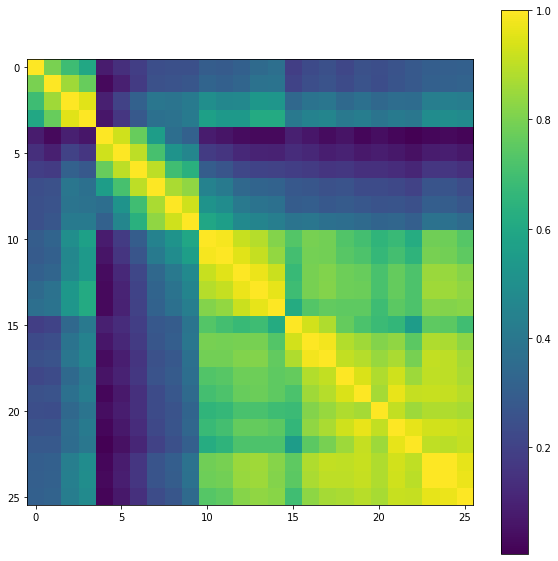

In [48]:
fig, ax = plt.subplots(figsize = (10, 10))
im = ax.imshow(mesures_debit_desaison[liste_stations].corr())
fig.colorbar(im)

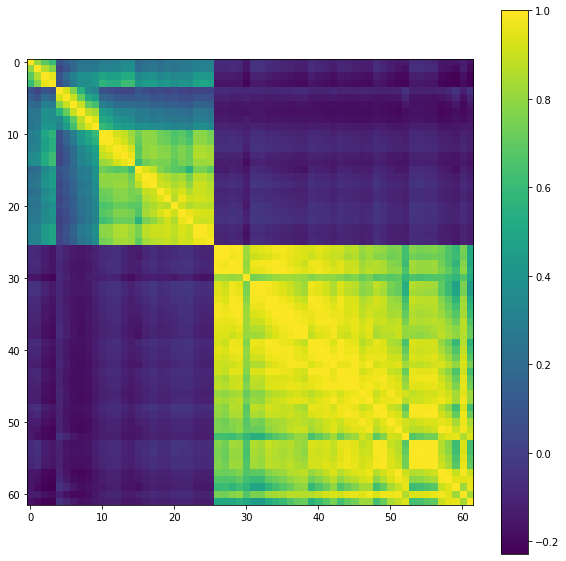

In [53]:
mesures_debit_desaison_pression = pd.concat([mesures_debit_desaison[liste_stations], mesures_debit_desaison.filter(regex="Pression.*")], axis = 1)
fig, ax = plt.subplots(figsize = (10, 10))
im = ax.imshow(mesures_debit_desaison_pression.corr())
fig.colorbar(im)

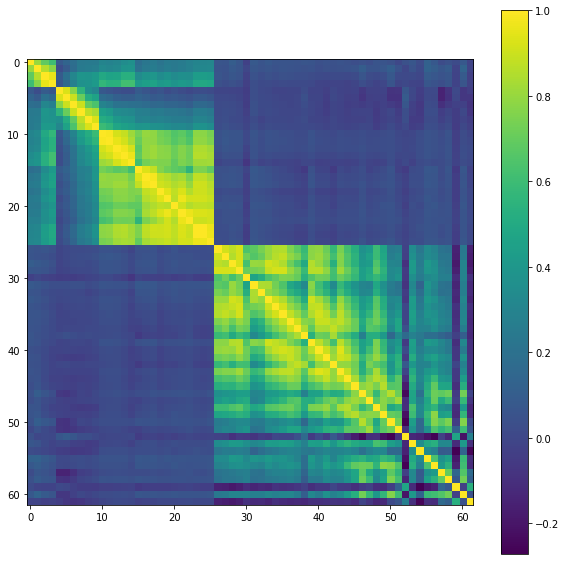

In [55]:
mesures_debit_desaison_vent_nord = pd.concat([mesures_debit_desaison[liste_stations], mesures_debit_desaison.filter(regex="Vent_Nord.*")], axis = 1)

fig, ax = plt.subplots(figsize = (10, 10))
im = ax.imshow(mesures_debit_desaison_vent_nord.corr())
fig.colorbar(im)

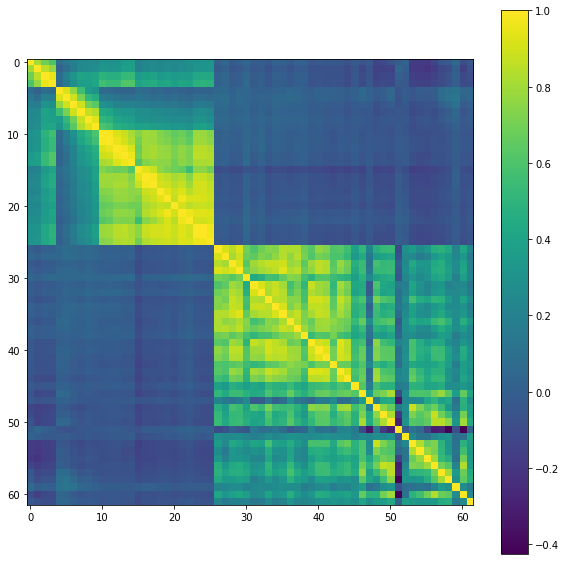

In [56]:
mesures_debit_desaison_vent_est = pd.concat([mesures_debit_desaison[liste_stations], mesures_debit_desaison.filter(regex="Vent_Est.*")], axis = 1)
fig, ax = plt.subplots(figsize = (10, 10))
im = ax.imshow(mesures_debit_desaison_vent_est.corr())
fig.colorbar(im)

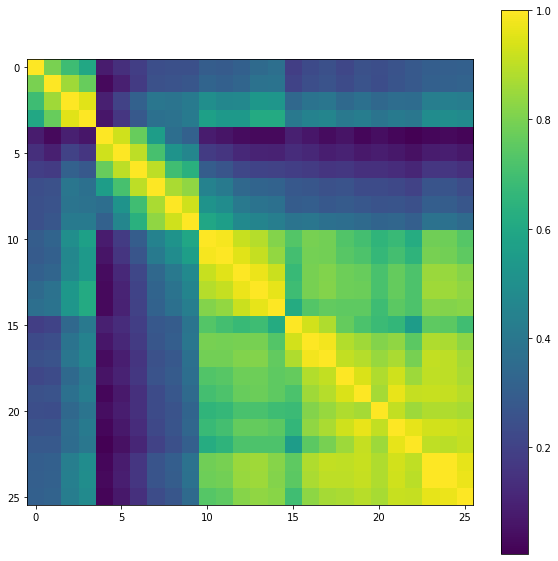

In [57]:
mesures_debit_desaison_vitesse_vent = pd.concat([mesures_debit_desaison[liste_stations], mesures_debit_desaison.filter(regex="Vitesse_Vent.*")], axis = 1)
fig, ax = plt.subplots(figsize = (10, 10))
im = ax.imshow(mesures_debit_desaison_vitesse_vent.corr())
fig.colorbar(im)

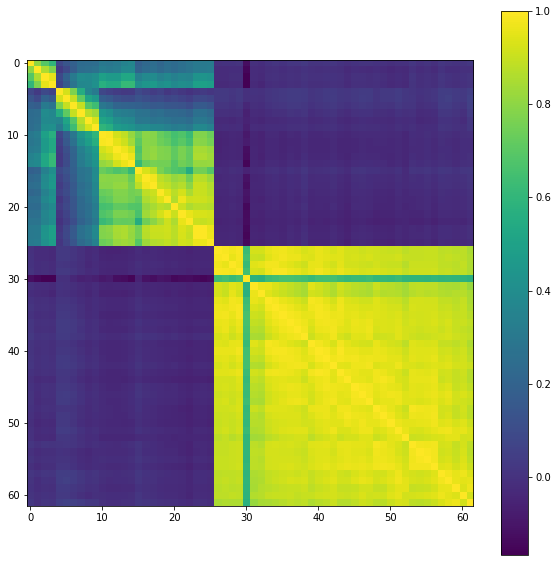

In [58]:
mesures_debit_desaison_temperature = pd.concat([mesures_debit_desaison[liste_stations], mesures_debit_desaison.filter(regex="Temperature.*")], axis = 1)
fig, ax = plt.subplots(figsize = (10, 10))
im = ax.imshow(mesures_debit_desaison_temperature.corr())
fig.colorbar(im)

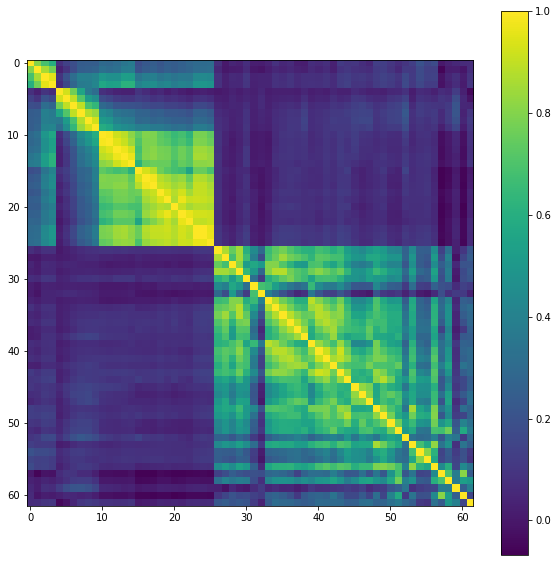

In [59]:
mesures_debit_desaison_humidite = pd.concat([mesures_debit_desaison[liste_stations], mesures_debit_desaison.filter(regex="Humidite.*")], axis = 1)
fig, ax = plt.subplots(figsize = (10, 10))
im = ax.imshow(mesures_debit_desaison_humidite.corr())
fig.colorbar(im)

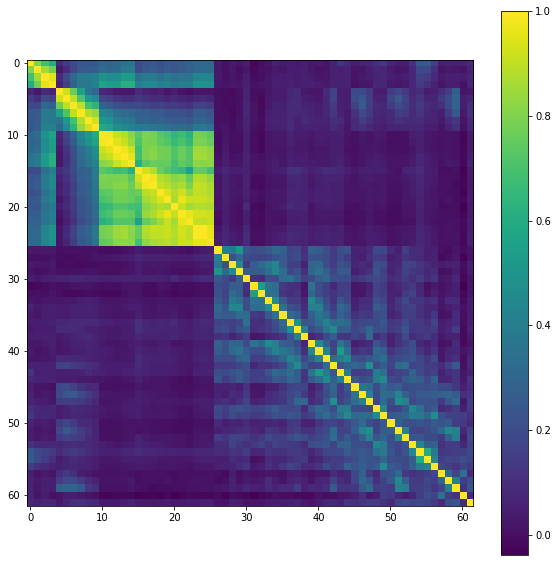

In [60]:
mesures_debit_desaison_precipitations = pd.concat([mesures_debit_desaison[liste_stations], mesures_debit_desaison.filter(regex="Precipitations.*")], axis = 1)
fig, ax = plt.subplots(figsize = (10, 10))
im = ax.imshow(mesures_debit_desaison_precipitations.corr())
fig.colorbar(im)

### Desaisonnalisation Méthode 2: gaussian smoothing
On essaye d'estimer la partie périodique de SC débit d'eau d'une station, en moyennant les lissages gaussiens de 11 années.


26it [00:00, 52.95it/s]
100%|████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 1135.20it/s]


,O0200020,O2620010,O6140010,O9000010,K0030020,K0100020,K0260020,K0550010,K0690010,K0910050,...,H0100020,H0400010,H0400020,H0800011,H0800012,H0810010,H1700010,H3930020,H4340020,H8100021
0,38.921634,130.031883,334.386736,525.287735,0.888085,4.289674,13.739790,38.939341,49.749687,65.572631,...,22.456614,56.537324,37.184125,36.916911,23.148556,54.21538,123.280993,356.070560,376.455622,815.984919
1,38.921634,130.031883,334.386736,525.287735,0.888085,4.289674,13.739790,38.939341,49.749687,65.572631,...,22.456614,56.537324,37.184125,36.916911,23.148556,54.21538,123.280993,356.070560,376.455622,815.984919
2,38.921634,130.031883,334.386736,525.287735,0.888085,4.289674,13.739790,38.939341,49.749687,65.572631,...,22.456614,56.537324,37.184125,36.916911,23.148556,54.21538,123.280993,356.070560,376.455622,815.984919
3,38.921634,130.031883,334.386736,525.287735,0.888085,4.289674,13.739790,38.939341,49.749687,65.572631,...,22.456614,56.537324,37.184125,36.916911,23.148556,54.21538,123.280993,356.070560,376.455622,815.984919
4,38.921634,130.031883,334.386736,525.287735,0.888085,4.289674,13.739790,38.939341,49.749687,65.572631,...,22.456614,56.537324,37.184125,36.916911,23.148556,54.21538,123.280993,356.070560,376.455622,815.984919
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48211,41.305161,154.315454,405.274481,698.387667,0.952283,4.657727,14.777748,42.330461,56.496258,77.469314,...,21.684184,56.432639,36.606886,33.418058,23.104307,52.25196,122.597000,363.979531,386.739268,831.034290
48212,41.305161,154.315454,405.274481,698.387667,0.952283,4.657727,14.777748,42.330461,56.496258,77.469314,...,21.684184,56.432639,36.606886,33.418058,23.104307,52.25196,122.597000,363.979531,386.739268,831.034290
48213,38.921634,130.031883,334.386736,525.287735,0.888085,4.289674,13.739790,38.939341,49.749687,65.572631,...,22.456614,56.537324,37.184125,36.916911,23.148556,54.21538,123.280993,356.070560,376.455622,815.984919
48214,38.921634,130.031883,334.386736,525.287735,0.888085,4.289674,13.739790,38.939341,49.749687,65.572631,...,22.456614,56.537324,37.184125,36.916911,23.148556,54.21538,123.280993,356.070560,376.455622,815.984919


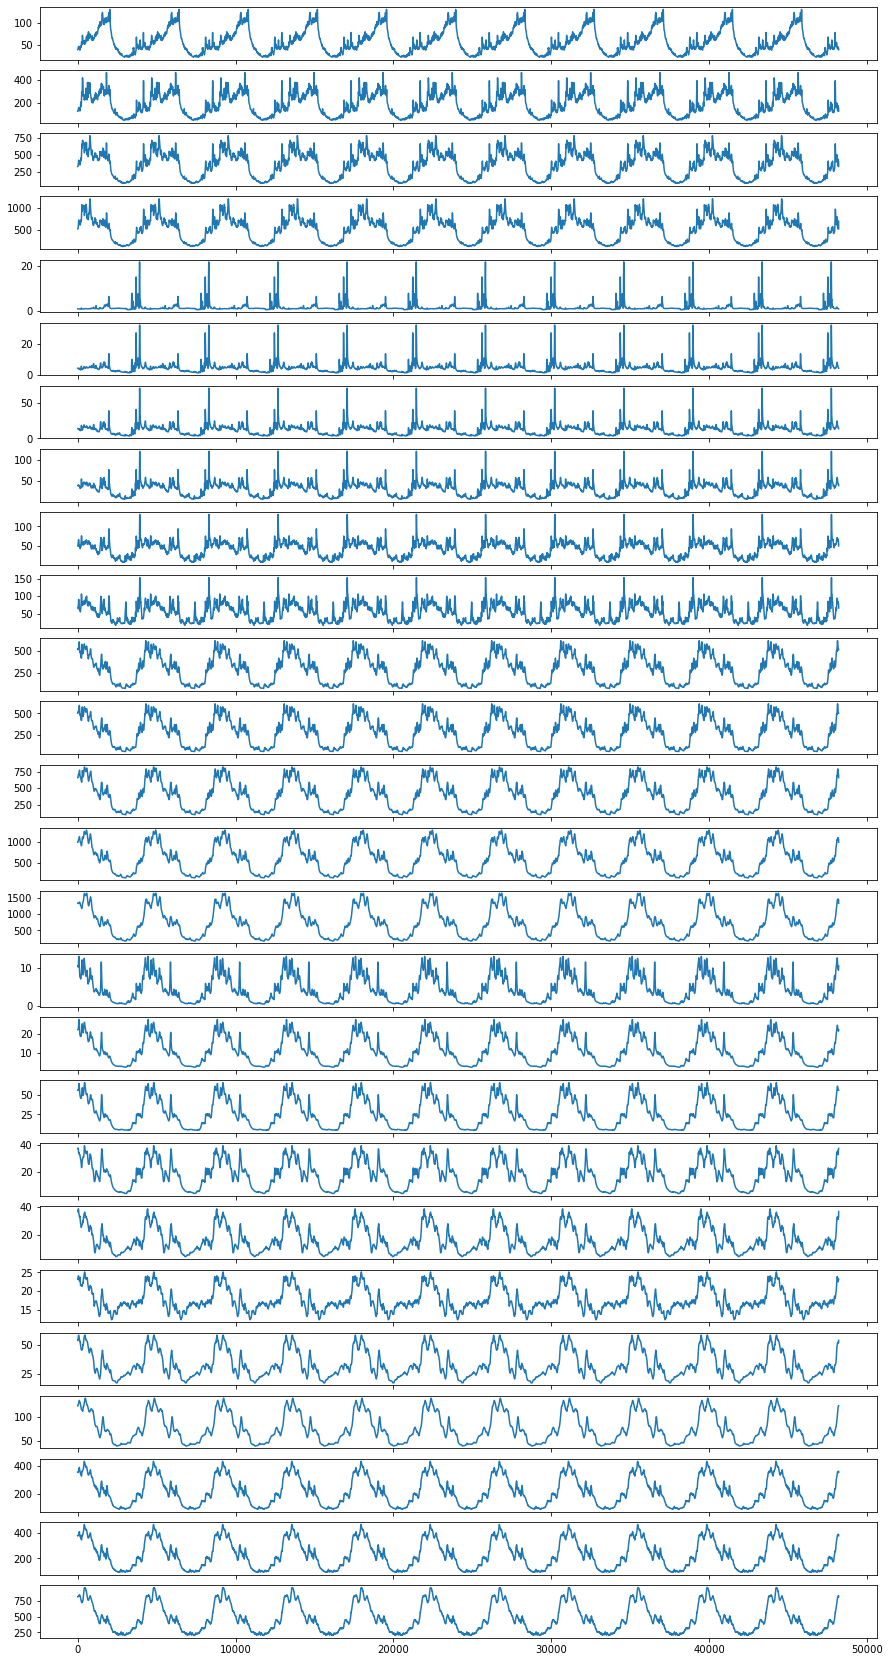

In [187]:
fig, axs = plt.subplots(len(stations_debit), 1, figsize = (15,30), sharex=True)
avg_gauss = pd.DataFrame()

for n,code in tqdm(enumerate(stations_debit["Code station"])):
    gauss_series = pd.DataFrame()
    for i in range(11):
        debit_eau_1y = pd.Series(mesures[code][4383*i: 4383*(i+1)])
        gauss_smooth = debit_eau_1y.rolling(window=24, win_type='gaussian', center=True).mean(std=25) #lissage par noyau guassien
        gauss_smooth = gauss_smooth.to_numpy()
        gauss_series[str(i)] = gauss_smooth
    avg = gauss_series.mean(axis=1)
    avg = avg.ffill().bfill()
    avg = avg.to_numpy()
    avg = np.resize(avg, len(mesures))
    avg_gauss[code] = avg.tolist()
    axs[n].plot(avg_gauss[code])
mesures_debit_desaison = pd.DataFrame()
for code in tqdm(stations_debit["Code station"]):
    mesures_debit_desaison[code] = mesures[code] - avg_gauss[code]
avg_gauss

26it [00:00, 388.44it/s]


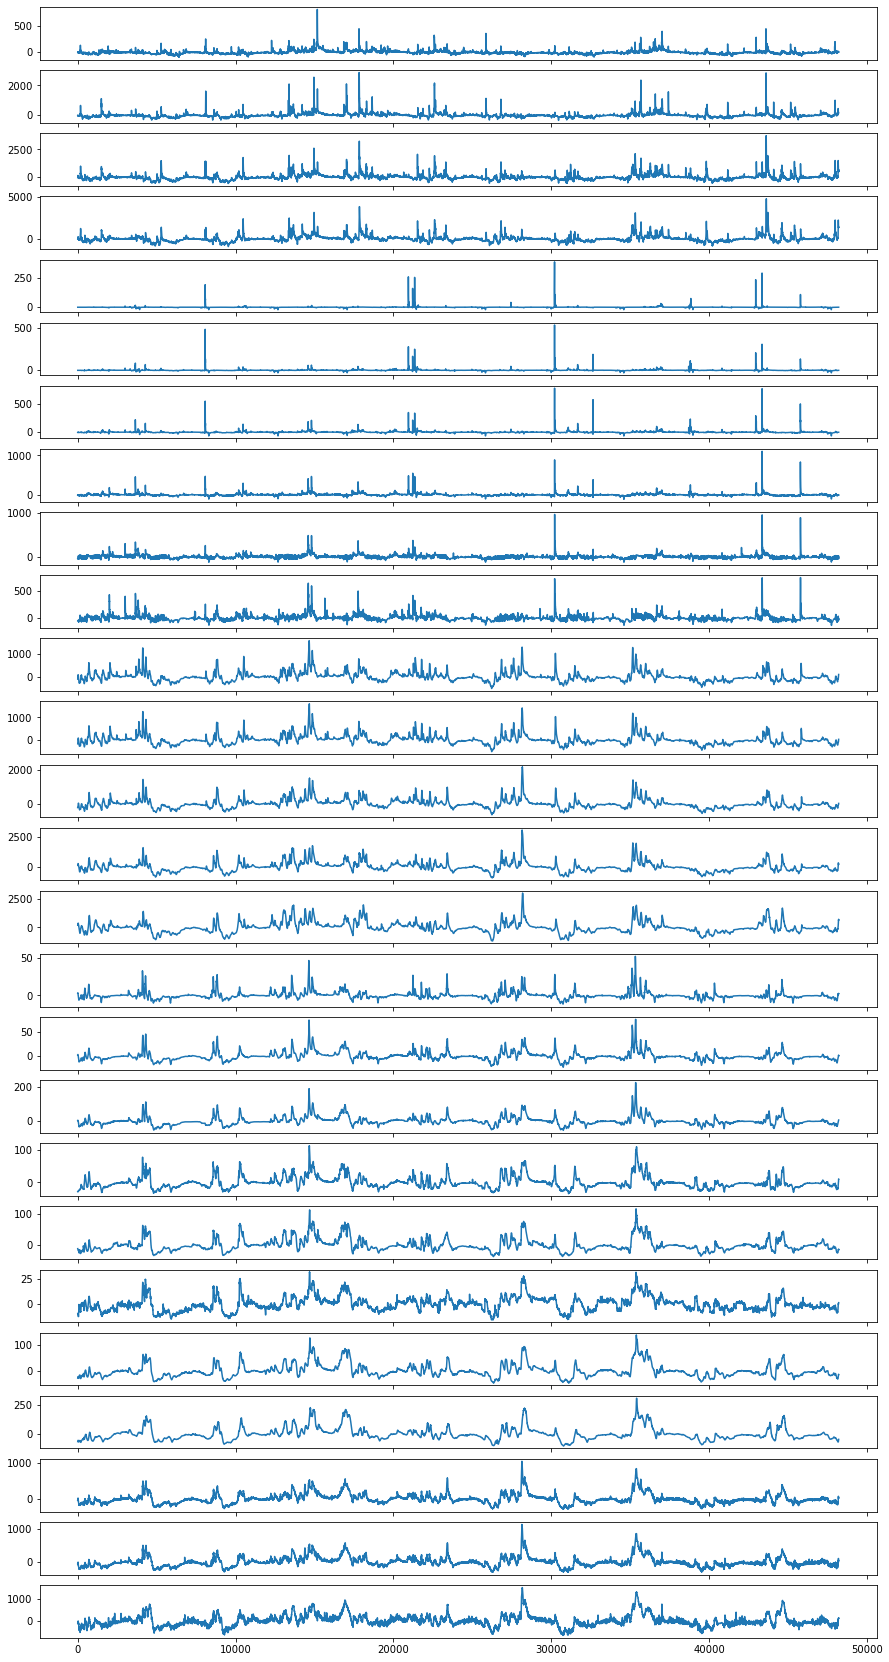

In [188]:
fig, axs = plt.subplots(len(stations_debit), 1, figsize = (15,30), sharex=True)

for n,code in tqdm(enumerate(stations_debit["Code station"])):
    axs[n].plot(mesures_debit_desaison[code])


26it [00:00, 39.47it/s]


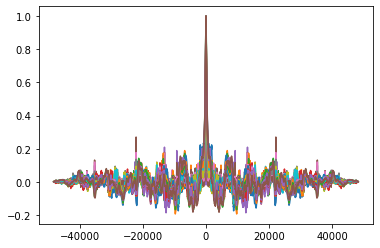

In [189]:

for n,code in tqdm(enumerate(stations_debit["Code station"])):
    corr= signal.correlate(mesures_debit_desaison[code], mesures_debit_desaison[code], mode = "full")
    corr /= np.max(corr)
    origine = len(mesures_debit_desaison)-1
    plt.plot([i-origine for i in range(len(mesures_debit_desaison)*2-1)], corr)


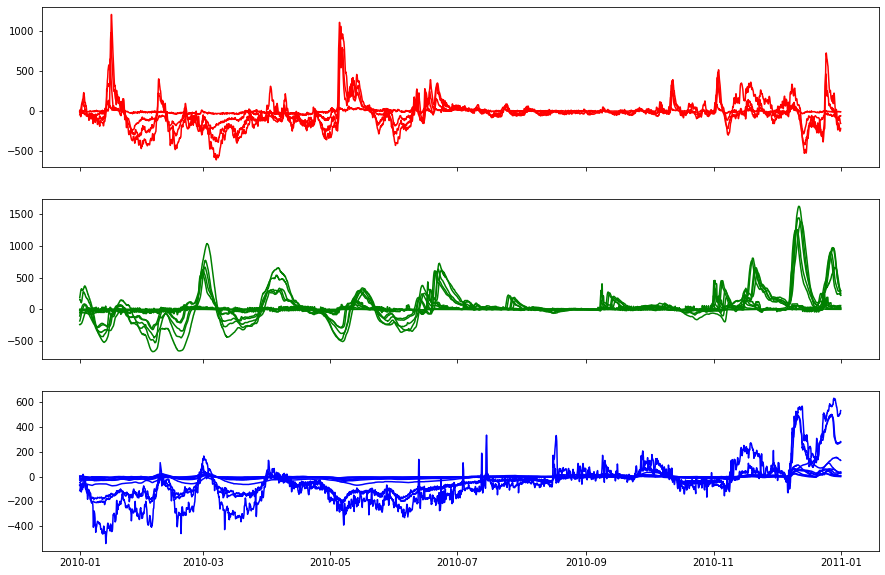

In [190]:
fig, axs = plt.subplots(n_cours_eau, 1, figsize = (15,10), sharex=True)
for i in range(n_cours_eau):
    stations = list(stations_debit[stations_debit["Cours eau"] == i]["Code station"])
    for code in stations:
        axs[i].plot(mesures_2010["Date"], mesures_debit_desaison[mesures["Date"].apply(lambda x: x.year == 2010)][code],
                   color = cours_eau_cmap(i))